#Vartiational Quantum Eigensolver based on Digital-Analog Quantum Computing (DAQC) approach

The following notebook implements VQE on DAQC for IQM Challenge at Womanium Hackathon

Team: RQC Hackathon Team
Creator: Artem Kuzmichev

In [1]:
!pip install qiskit -q --no-warn-conflicts
!pip install pylatexenc -q --no-warn-conflicts
!pip install qutip -q --no-warn-conflicts

In [2]:
import numpy as np
import qutip as qt

from typing import List 
from matplotlib import pyplot as plt
%matplotlib inline

from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

##Qiskit Nature precalculations of Hamiltonian

In [3]:
!pip install qiskit_nature[pyscf] -q --no-warn-conflicts
!pip install pyscf -q --no-warn-conflicts

In [4]:
from qiskit_nature.settings import settings
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

settings.dict_aux_operators = True

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op["ElectronicEnergy"])

Fermionic Operator
register length=4, number terms=36
  -1.2563390730032498 * ( +_0 -_0 )
+ -0.47189600728114245 * ( +_1 -_1 )
+ -1.2563390730032498 * ( +_2 -_2 )
+ -0.47189600728114245 * ( +_3 -_3 )
+ -0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ -0. ...


In [5]:
qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op["ElectronicEnergy"])
print(qubit_op)

-0.8105479805373279 * IIII
+ 0.1721839326191554 * IIIZ
- 0.22575349222402372 * IIZI
+ 0.17218393261915543 * IZII
- 0.2257534922240237 * ZIII
+ 0.12091263261776627 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.045232799946057826 * YYYY
+ 0.045232799946057826 * XXYY
+ 0.045232799946057826 * YYXX
+ 0.045232799946057826 * XXXX
+ 0.1661454325638241 * ZIIZ
+ 0.1661454325638241 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776627 * ZZII


In [6]:
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(
    second_q_op["ElectronicEnergy"], num_particles=es_problem.num_particles
)
print(qubit_op)

-1.0523732457728594 * II
+ 0.39793742484317784 * IZ
- 0.3979374248431793 * ZI
- 0.011280104256233686 * ZZ
+ 0.18093119978423117 * XX


In [7]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


##Hamiltonian with ZZ-interaction

In [8]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

In [15]:
num_qubits = 2
hamiltonian = create_zz_hamiltonian(num_qubits, [[0, 1]], [1]) 
analog_block = HamiltonianGate(data=hamiltonian, time=3) 

ham_matrix = HamiltonianGate(data=hamiltonian, time=2).params[0]
print(np.array_str(ham_matrix.real.astype('int'), precision=1, suppress_small=True))

[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]


##Building the circuit

In [11]:
op = 0

for pauli_op0 in I, X, Z:
    for pauli_op1 in I, X, Z:
        op += np.random.rand() * pauli_op0 ^ pauli_op1
op

PauliSumOp(SparsePauliOp(['II', 'IX', 'IZ', 'XI', 'XX', 'XZ', 'ZI', 'ZX', 'ZZ'],
              coeffs=[0.07389538+0.j, 0.81609935+0.j, 0.31838032+0.j, 0.8897417 +0.j,
 0.77938041+0.j, 0.29963809+0.j, 0.77817835+0.j, 0.81144021+0.j,
 0.04349359+0.j]), coeff=1.0)

In [12]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.46242


###Ansatz

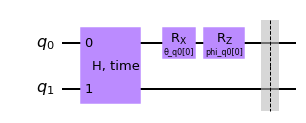

In [16]:
n_layers = 1
no_qubits = op.num_qubits

def create_ansatz(no_qubits, n_layers=1):
    theta_list = [ParameterVector(f'θ_q{i}', length=n_layers) for i in range(no_qubits)]
    phi_list = [ParameterVector(f'phi_q{i}', length=n_layers) for i in range(no_qubits)]

    times_list = ParameterVector('time', length=n_layers)


    # Create a quantum circuit that is used for the ansatz
    ansatz_ = QuantumCircuit(op.num_qubits)

    for layer in range(n_layers):
        analog_block = HamiltonianGate(data=hamiltonian, time=times_list[layer], label=f'H, time') 
        ansatz_.append(analog_block, list(range(no_qubits)))

        # add some single-qubit gates
        for i in range(no_qubits - 1):
            ansatz_.rx(theta_list[i][layer], i)
            ansatz_.rz(phi_list[i][layer], i)

        ansatz_.barrier()
    return ansatz_

ansatz = create_ansatz(no_qubits, n_layers)
ansatz.draw('mpl')

###SPSA optimization technique

In [21]:
def spsa_vqe_optimization(ansatz, n_layers, qi):
    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    full_vqc = ansatz.copy()

    for layer in range(n_layers):
        print(f'learning layer {layer}')
        print(full_vqc.draw())

        spsa = SPSA(maxiter=80)
        vqe = VQE(full_vqc, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
        result = vqe.compute_minimum_eigenvalue(operator=op)

        print(result.optimal_parameters)
        print(f'VQE result for layer {layer}: {result.eigenvalue.real:.5f}')

        full_vqc.assign_parameters(result.optimal_parameters, inplace=True)
        full_vqc.compose(ansatz.copy(), inplace=True)
    
    return result, values

In [18]:
seed = 20
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')

###Digital VQE

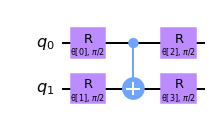

In [22]:
from qiskit.circuit.library import RealAmplitudes

no_qubits = op.num_qubits

# Create a quantum circuit that is used for the ansatz
ansatz =  RealAmplitudes(num_qubits=no_qubits, reps=1,
                        entanglement='linear')

ansatz.decompose().decompose().draw('mpl')

In [23]:
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

n_layers = 3

ansatz =  RealAmplitudes(num_qubits=no_qubits, reps=1,
                        entanglement='linear')
result, values = spsa_vqe_optimization(ansatz, n_layers, qi)

learning layer 0
     ┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘
{ParameterVectorElement(θ[0]): -2.315239975746205, ParameterVectorElement(θ[1]): -0.8541745645064363, ParameterVectorElement(θ[2]): -0.8278787842259071, ParameterVectorElement(θ[3]): -0.20498524944034816}
VQE result for layer 0: -1.50237
learning layer 1
     »
q_0: »
     »
q_1: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                            ├»
«     │  RealAmplitudes(-2.31523997574621,-0.854174564506436,-0.827878784225907,-0.204985249440348) │»
«q_1: ┤1                                                                                            ├»
«     └────────────────────────────────────────────

### No-noise DAQC VQE

In [24]:
seed = 20
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

n_layers = 3
ansatz = create_ansatz(no_qubits)

result1, values1 = spsa_vqe_optimization(ansatz, n_layers, qi)

learning layer 0
     ┌──────────┐┌─────────────┐┌───────────────┐ ░ 
q_0: ┤0         ├┤ Rx(θ_q0[0]) ├┤ Rz(phi_q0[0]) ├─░─
     │  H, time │└─────────────┘└───────────────┘ ░ 
q_1: ┤1         ├─────────────────────────────────░─
     └──────────┘                                 ░ 
{ParameterVectorElement(phi_q0[0]): -1.5721104841745654, ParameterVectorElement(time[0]): -0.859538547434622, ParameterVectorElement(θ_q0[0]): -4.457319601153028}
VQE result for layer 0: -0.80757
learning layer 1
     ┌──────────┐┌───────────────────────┐┌───────────────────────┐ ░ »
q_0: ┤0         ├┤ Rx(-4.45731960115303) ├┤ Rz(-1.57211048417457) ├─░─»
     │  H, time │└───────────────────────┘└───────────────────────┘ ░ »
q_1: ┤1         ├───────────────────────────────────────────────────░─»
     └──────────┘                                                   ░ »
«     ┌──────────┐┌─────────────┐┌───────────────┐ ░ 
«q_0: ┤0         ├┤ Rx(θ_q0[0]) ├┤ Rz(phi_q0[0]) ├─░─
«     │  H, time │└─────────────┘└───

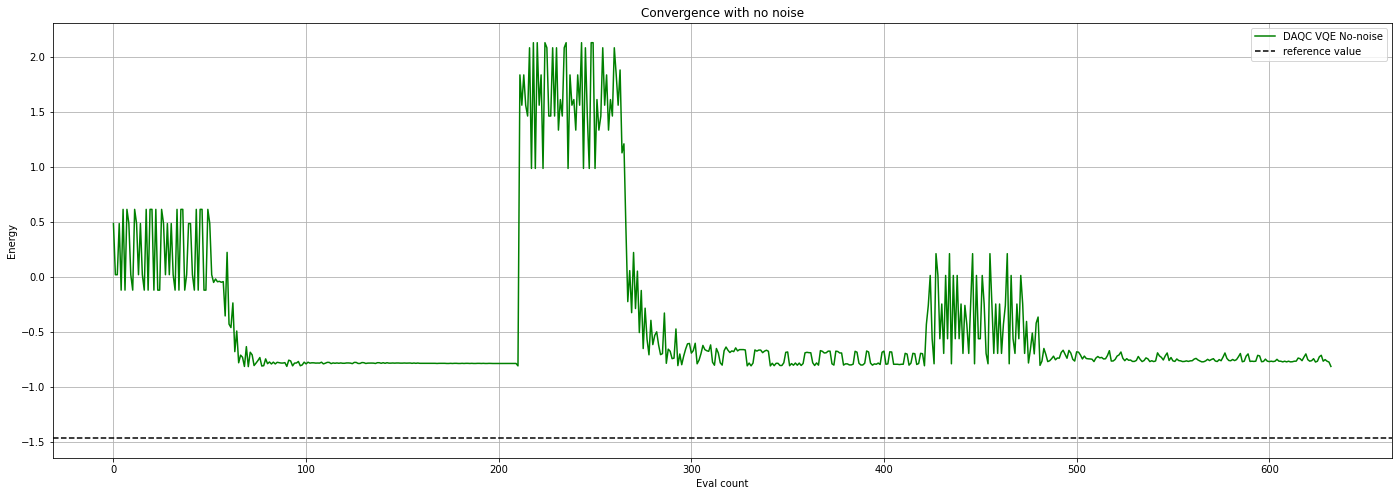

In [33]:
plt.figure(figsize=(24, 8))
plt.plot(np.arange(len(values1)), values1, color='g', label='DAQC VQE No-noise')
plt.axhline(y=ref_value, color='k', linestyle='--', label='reference value')
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with no noise')
plt.grid()
plt.legend()
plt.show()

##Noise

In [26]:
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

device_backend = FakeVigo()
backend = Aer.get_backend('aer_simulator')

noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

qi_noise = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['sx', 'measure', 'x', 'cx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]



In [27]:
n_layers = 3

seed = 20
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
ansatz = create_ansatz(no_qubits)

result2, values2 = spsa_vqe_optimization(ansatz, n_layers, qi_noise)

learning layer 0
     ┌──────────┐┌─────────────┐┌───────────────┐ ░ 
q_0: ┤0         ├┤ Rx(θ_q0[0]) ├┤ Rz(phi_q0[0]) ├─░─
     │  H, time │└─────────────┘└───────────────┘ ░ 
q_1: ┤1         ├─────────────────────────────────░─
     └──────────┘                                 ░ 
{ParameterVectorElement(phi_q0[0]): -1.5715429760944715, ParameterVectorElement(time[0]): -0.8715440329846671, ParameterVectorElement(θ_q0[0]): -4.468622936751615}
VQE result for layer 0: -0.58923
learning layer 1
     ┌──────────┐┌───────────────────────┐┌───────────────────────┐ ░ »
q_0: ┤0         ├┤ Rx(-4.46862293675161) ├┤ Rz(-1.57154297609447) ├─░─»
     │  H, time │└───────────────────────┘└───────────────────────┘ ░ »
q_1: ┤1         ├───────────────────────────────────────────────────░─»
     └──────────┘                                                   ░ »
«     ┌──────────┐┌─────────────┐┌───────────────┐ ░ 
«q_0: ┤0         ├┤ Rx(θ_q0[0]) ├┤ Rz(phi_q0[0]) ├─░─
«     │  H, time │└─────────────┘└──

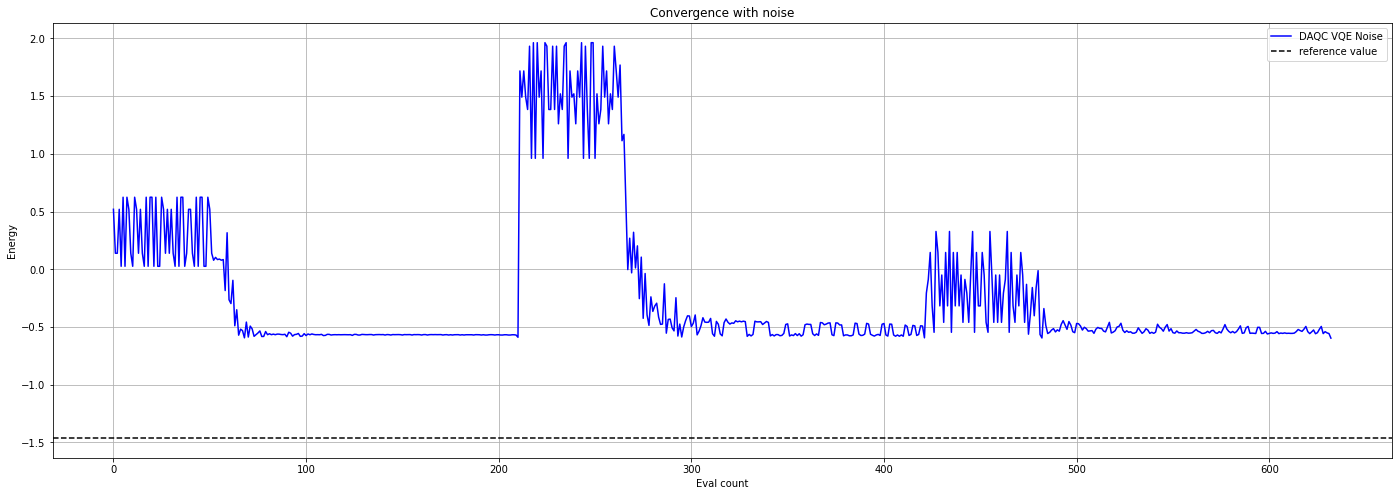

In [34]:
plt.figure(figsize=(24, 8))
plt.plot(np.arange(len(values2)), values2, color='b', label='DAQC VQE Noise')
plt.axhline(y=ref_value, color='k', linestyle='--', label='reference value')
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with noise')
plt.grid()
plt.legend()
plt.show()

##Summary

In [30]:
print(f'Reference value: {ref_value:.5f}')
print(f'DQC VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'DAQC VQE on Aer qasm simulator (no noise): {result1.eigenvalue.real:.5f}')
print(f'DAQC VQE on Aer qasm simulator (with noise): {result2.eigenvalue.real:.5f}')

Reference value: -1.46242
DQC VQE on Aer qasm simulator (no noise): -1.48098
DAQC VQE on Aer qasm simulator (no noise): -0.81260
DAQC VQE on Aer qasm simulator (with noise): -0.59677


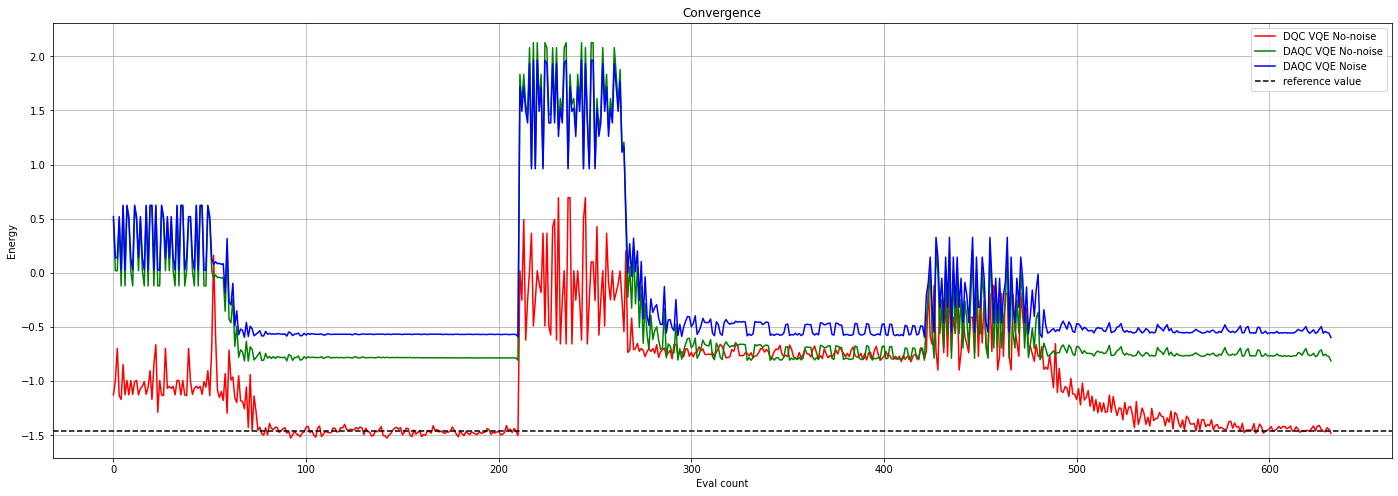

In [35]:
plt.figure(figsize=(24, 8))

plt.plot(np.arange(len(values)), values, color='r', label='DQC VQE No-noise')
plt.plot(np.arange(len(values1)), values1, color='g', label='DAQC VQE No-noise')
plt.plot(np.arange(len(values2)), values2, color='b', label='DAQC VQE Noise')

plt.axhline(y=ref_value, color='k', linestyle='--', label='reference value')
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence')
plt.grid()
plt.legend()
plt.show()